# Maximize the correlation between the ratio of bad pLDDT and our metrics
Because iupred_auc_normalized, repeat_6mers_normalized and non_repeat_6mers_normalized on their own just got a small correlation, we investigate here what happens if we just compute weights that maximize correlation. Can we use these to predict?

In [1]:
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df_with_outliers = pd.concat(dfs)

In [3]:
# Filter to sequences that have IUPred AUC and remove outliers
df_with_outliers = df_with_outliers[df_with_outliers['iupred_auc'].notnull()]
df_with_outliers['iupred_auc_normalized'] = df_with_outliers['iupred_auc'] / df_with_outliers['seq_len']
df_with_outliers.nlargest(n=10, columns='iupred_auc_normalized')
df = df_with_outliers[df_with_outliers['iupred_auc_normalized'] < 1.6].copy()

In [4]:
# Use 6mer counts of 2k most common and normalize
df['repeat_6mers'] = df['repeat_6mers_2000']
df['non_repeat_6mers'] = df['non_repeat_6mers_2000']
df = df[(df['repeat_6mers'].notnull() & df['non_repeat_6mers'].notnull() & df['aa_distr_js'].notnull())].copy()
df['repeat_6mers_normalized'] = df['repeat_6mers'] / df['seq_len']
df['non_repeat_6mers_normalized'] = df['non_repeat_6mers'] / df['seq_len']

In [5]:
df.describe()

,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,...,freq_neg_charge,freq_polar,freq_non_polar,IEP,suboptim_compress,iupred_auc_normalized,repeat_6mers,non_repeat_6mers,repeat_6mers_normalized,non_repeat_6mers_normalized
count,1.056360e+06,514617.000000,1.056360e+06,1.056360e+06,1.056360e+06,1.056360e+06,1.056360e+06,513489.000000,1.056360e+06,1.056360e+06,...,1.056360e+06,1.056360e+06,1.056360e+06,1.056360e+06,207722.000000,1.056360e+06,1.056360e+06,1.056360e+06,1.056360e+06,1.056360e+06
mean,3.855214e+02,0.570992,3.932188e+01,8.158377e+01,8.522043e+01,2.427842e-01,6.158025e+01,-0.311985,4.908781e-01,9.778343e-01,...,1.159406e-01,5.112160e-01,2.319420e-01,7.156469e+00,0.133778,1.406801e-01,4.908781e-01,9.778343e-01,1.013082e-03,2.433605e-03
std,3.108608e+02,1.108974,1.512894e+01,1.432802e+01,1.663241e+01,2.701710e-01,1.207424e+02,0.317157,4.024752e+00,4.935270e+00,...,3.887318e-02,7.148853e-02,5.426308e-02,1.925671e+00,0.101513,1.881259e-01,4.024752e+00,4.935270e+00,7.667400e-03,1.149621e-02
min,1.800000e+01,0.000000,1.390000e+00,2.307730e+01,2.217000e+01,0.000000e+00,0.000000e+00,-0.987435,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,4.050000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.780000e+02,0.000000,2.796000e+01,7.327700e+01,8.219000e+01,3.400000e-02,2.276000e-01,-0.564031,0.000000e+00,0.000000e+00,...,9.420000e-02,4.684000e-01,1.973000e-01,5.503500e+00,0.054900,6.807276e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.120000e+02,0.000000,3.537000e+01,8.621990e+01,9.259500e+01,1.327000e-01,5.627000e-01,-0.345590,0.000000e+00,0.000000e+00,...,1.174000e-01,5.092000e-01,2.283000e-01,6.543700e+00,0.112800,4.800000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.860000e+02,1.000000,4.686000e+01,9.303640e+01,9.644000e+01,3.676000e-01,7.737430e+01,-0.103959,0.000000e+00,1.000000e+00,...,1.381000e-01,5.513000e-01,2.614000e-01,8.936000e+00,0.194200,2.508322e-01,0.000000e+00,1.000000e+00,0.000000e+00,1.353180e-03
max,2.699000e+03,46.000000,9.738000e+01,9.875400e+01,9.887000e+01,1.000000e+00,2.123831e+03,0.918797,3.860000e+02,6.730000e+02,...,8.889000e-01,1.000000e+00,9.875000e-01,1.200000e+01,0.680400,1.342777e+00,3.860000e+02,6.730000e+02,9.250000e-01,7.719298e-01


In [6]:
from scipy.stats import spearmanr

rho, p = spearmanr(df['ratio_bad_plddt'], df['iupred_auc_normalized'])
print(f'Spearman rank correlation (IUPred AUC): {"{0:.4f}".format(rho)}')
rho1, p1 = spearmanr(df['ratio_bad_plddt'], df['repeat_6mers_normalized'])
print(f'Spearman rank correlation (Repeat): {"{0:.4f}".format(rho1)}')
rho2, p2 = spearmanr(df['ratio_bad_plddt'], df['non_repeat_6mers_normalized'])
print(f'Spearman rank correlation (Non-repeat): {"{0:.4f}".format(rho2)}')

Spearman rank correlation (IUPred AUC): 0.5024
Spearman rank correlation (Repeat): 0.2878
Spearman rank correlation (Non-repeat): 0.1590


In [7]:
weights = np.asarray([0.33, 0.33, 0.33])
all_weights = []

In [8]:
import scipy.optimize as opt

features = ['iupred_auc_normalized', 'repeat_6mers_normalized', 'non_repeat_6mers_normalized']

def fun(w):
    r, _ = spearmanr(df['ratio_bad_plddt'], df[features] @ w)
    # abs to turn into minimization problem
    return -np.abs(r)

for _ in range(5):
    all_weights.append(weights)
    res = opt.minimize(fun, weights)
    weights = res.x
    print(f'Spearman rank correlation (Optimized): {"{0:.4f}".format(-res.fun)}')

Spearman rank correlation (Optimized): 0.5375
Spearman rank correlation (Optimized): 0.5375
Spearman rank correlation (Optimized): 0.5388
Spearman rank correlation (Optimized): 0.5404
Spearman rank correlation (Optimized): 0.5404


In [9]:
x = weights[0] * df['iupred_auc_normalized'] + weights[1] * df['repeat_6mers_normalized'] + weights[2] * df['non_repeat_6mers_normalized']
rho_x, p_x = spearmanr(df['ratio_bad_plddt'], x)
print(f'Spearman rank correlation (Optimized): {"{0:.4f}".format(rho_x)}')

Spearman rank correlation (Optimized): 0.5404


In [10]:
all_weights = np.asarray(all_weights)

xs = [spearmanr(df['ratio_bad_plddt'], w[0] * df['iupred_auc_normalized'] + w[1] * df['repeat_6mers_normalized'] + w[2] * df['non_repeat_6mers_normalized'])[0] for w in all_weights]

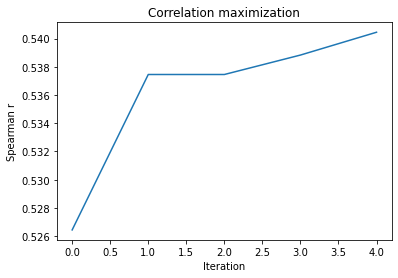

In [11]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(range(len(all_weights)), xs)
ax.set_title('Correlation maximization')
ax.set_ylabel('Spearman r')
ax.set_xlabel('Iteration')

plt.show()

### Now also with Jensen-Shannon

In [12]:
weights_js = np.asarray([0.17525,0.26599,0.23276,0.34607])
all_weights_js = []

In [13]:
import scipy.optimize as opt

features = ['iupred_auc_normalized', 'repeat_6mers_normalized', 'non_repeat_6mers_normalized', 'aa_distr_js']

def fun(w):
    r, _ = spearmanr(df['ratio_bad_plddt'], df[features] @ w)
    # abs to turn into minimization problem
    return -np.abs(r)

for _ in range(5):
    all_weights_js.append(weights_js)
    res = opt.minimize(fun, weights_js)
    weights_js = res.x
    print(f'Spearman rank correlation (Optimized): {"{0:.4f}".format(-res.fun)}')

Spearman rank correlation (Optimized): 0.5586
Spearman rank correlation (Optimized): 0.5588
Spearman rank correlation (Optimized): 0.5588
Spearman rank correlation (Optimized): 0.5588
Spearman rank correlation (Optimized): 0.5588
